## Model testing and selection 
> In this notebook we test various RNN models to predict a company's following day closing stock price.
At the end we select one model to train all of our stocks.

###  1) Import data_manager module and other libraries
    
     The data_manager module has helper classes and methods for working with our stock data.
     
   > The module has the following class that we will use in this notebook:

   > ###### SimpleSequence -
   Sequence class that creates input (x) and target (y) for RNN training or prediction,
        based on given window size (x) and target (y) lengths.
        The sequence is created from end of day normalized adjusted close stock pricess.

> ###### MultiSequence -
   Sequence class that creates input (x) and target (y) for RNN training or prediction,
        based on given window size (x) and target (y) lengths.
        The sequence is created from three features i) end of day normalized adjusted close stock pricess
        ii) log normal returns and iii) normalized MFI index.
        
 We will also use a few other helper methods such as  `'companies()'` and `'split_data()'`  methods from data_manager module.

In [1]:
%load_ext autoreload
%aimport data_manager
%autoreload 1

from data_manager import *

###  2) Import company list
> Here we read a csv file and import a list of company trade symbols

In [2]:
#read list of companies from csv file
stocks = companies()
tickers = stocks.values.tolist()

#Select stock to perform tests
ticker = tickers[23][1]

print("Stock ticker selected for testing: {}".format(ticker))

Stock ticker selected for testing: SNAP


### 3) RNN Models
> In this step we select four RNN models that we will train and evaluate how accurate they are on unseen data.

In [3]:
import numpy as np
import pandas as pd

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Bidirectional
from keras.optimizers import RMSprop

def fixed_model(X,y, learn_rate):
    """
    RNN model with one LSTM layer (output of 5) and 1 fully connected output tanh layer    
    
    Parameter
    -----------
    X: numpy array
              input sequence data.
    
    y: numpy array
              target sequence data.
    
    learn_rate: float
            Neural network learning rate.
    """
    model = Sequential()
    model.add(LSTM(5,input_shape=(X.shape[1:])))
    model.add(Dense(y.shape[1], activation='tanh'))
      
    # compile the model
    optimizer = RMSprop(lr=learn_rate)
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

def dynamic_model(X,y, learn_rate):
    """
    RNN model with one LSTM layer (output based on input sequence length) and 1 fully connected output tanh layer    
    
    Parameter
    -----------
    X: numpy array
              input sequence data.
    
    y: numpy array
              target sequence data.
    
    learn_rate: float
            Neural network learning rate.
    """
    model = Sequential()
    model.add(LSTM(X.shape[1],input_shape=(X.shape[1:])))
    model.add(Dense(y.shape[1], activation='tanh'))
      
    # compile the model
    optimizer = RMSprop(lr=learn_rate)
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

def bidirectional_model(X,y, learn_rate):
    """
    Bidirectional RNN model with one LSTM layer (output based on input sequence length), 
    one fully connected layer (output based on input sequence length) 
    and 1 fully connected output tanh layer    
    
    Parameter
    -----------
    X: numpy array
              input sequence data.
    
    y: numpy array
              target sequence data.
    
    learn_rate: float
            Neural network learning rate.
    """
    model = Sequential()
    model.add(Bidirectional(LSTM(X.shape[1],return_sequences=False), input_shape=(X.shape[1:])))
    model.add(Dense(X.shape[1]))
    model.add(Dense(y.shape[1], activation='tanh'))
      
    # compile the model
    optimizer = RMSprop(lr=learn_rate)
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

def stacked_model(X,y, learn_rate):
    """
    Stacked RNN model with two LSTM layers and 1 fully connected output tanh layer.
    First LSTM layer has output of 10 and the second has 5.
    
    Parameter
    -----------
    X: numpy array
              input sequence data.
    
    y: numpy array
              target sequence data.
    
    learn_rate: float
            Neural network learning rate.
    """
    model = Sequential()
    model.add(LSTM(10,return_sequences=True, input_shape=(X.shape[1:])))
    model.add(LSTM(5))
    model.add(Dense(y.shape[1], activation='tanh'))
      
    # compile the model
    optimizer = RMSprop(lr=learn_rate)
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

#Create list of our models for use by the testing function.
models =[]
models.append(("Fixed",fixed_model))
models.append(("Dynamic",dynamic_model))
models.append(("Bidirectional",bidirectional_model))
models.append(("Stacked",stacked_model))

Using TensorFlow backend.


### 4) Testing function
> Here we define a `'test_model()'` function to evaluate each RNN model.

In [4]:
from collections import OrderedDict

def test_model(ticker,epochs,models,seq,window_sizes):
    """
    Function to test the performance of our RNN models     
    
    Parameter
    -----------
    stock:  str
            Compnay trade ticker.
    
    epoch:  int
            Number of epochs to train RNN.
    
    models: list of RNN model functions  
            Each item is a tuple where 1st item is string name of model
            and the 2nd is a model function that accepts X,y and learn_rate paramenter.
    
    seq:    Data sequence object
            Object that has input X and target y sequence data.
    
    window_sizes: list
                  A list of different window size (sequence length X input) to test.  
    Returns:
    ---------
    Returns an ordered dictionary with the result of the model testing as six list;
    'Window Size', 'Sequence Name','Model Name',
    'Training Error','Testing Error' and 'Param Count'.
    """
    #test result data
    sizes = []
    #seq_name = []
    model_name = []
    train_errors = []
    test_errors = []
    param_count = []
    
    for window_size in window_sizes:
        print("\nWindow size: {}".format(window_size))
        print('----------------')
        for model_item in models:
            seq_obj = seq[1](ticker,window_size,1)
            X_train,y_train,X_test,y_test = split_data(seq_obj)
            model = model_item[1](X_train,y_train,0.001)
            
            # fit model!
            model.fit(X_train, y_train, epochs=epochs, batch_size=50, verbose=0)

            # print out training and testing errors
            training_error = model.evaluate(X_train, y_train, verbose=0)
            testing_error = model.evaluate(X_test, y_test, verbose=0)
            msg = " > Model: {0:<15} Param count: {1:} \tTraining error: {2:.4f}\tTesting error: {3:.4f}"
            print(msg.format(model_item[0],model.count_params(),training_error,testing_error))

            #update result variables
            param_count.append(model.count_params())
            sizes.append(window_size)
            #seq_name.append(seq[0])
            model_name.append(model_item[0])
            train_errors.append(float("{0:.4f}".format(training_error)))
            test_errors.append(float("{0:.4f}".format( testing_error)))

    table= OrderedDict()
    table['Window Size'] = sizes
    table['Sequence Name'] =  [seq[0] for _ in range(len(sizes))]
    table['Model Name'] = model_name
    table['Ticker'] = [ticker for _ in range(len(sizes))]
    table['Training Error'] = train_errors
    table['Testing Error'] = test_errors
    table['Param Count'] = param_count
        
    return table


def update_test_table(*argv):
    """Updates a model testing table 
    """
    file_path = "./data/model_test.csv"
    
    table = pd.read_csv(file_path)
    tickers = set( table['Ticker'].values.tolist())
    
    for item in argv:

        #first check if already exist 
        check = item['Ticker'][0]
        if check in tickers:
            #drop items
            idx = table[(table['Ticker']== check)  &  (table['Sequence Name']== item['Sequence Name'][0])].index
            table =  table.drop(idx)

        #append current test
        table = table.append(pd.DataFrame(item))

    table = table.reset_index(drop=True)
    table.to_csv(file_path, index = False)

def get_test_table():
    """Get testing table and returned as DataFrame
    """
    file_path = "./data/model_test.csv"
    return pd.read_csv(file_path)


### 5) Perform model testing
> We test each model using a one feature input sequence and a three feature  input sequence of different sequence size or window size.

> * The first test uses the `'SimpleSequence()'` class from the `data_manager` to evaluate how well it performs with the four RNN
models.  The `'SimpleSequence()'` is a one feature sequence based on normalized stock prices.   


> * In the second test we use the `'MultiSequence()'` class from the `data_manager`.  The `'MultiSequence()'` is a three normalize feature sequence; closing stock prices, log normal daily returns and MFI index.


> * The goals of the testing are to 1) decide which input sequence is better, 2) select the best performing window size  and 3) choose the best RNN model that best captures the target variable.

In [5]:
seed = 7
np.random.seed(seed)

#Model testing variables
epochs =100
window_sizes =[5,7,10,20]

In [6]:
print("*** Simple Sequence Model Test for {} ***".format(ticker))
print("=" * 45)

seq_name = ('Simple',SimpleSequence)

test_1  = test_model(ticker,epochs,models,seq_name,window_sizes)
update_test_table(test_1)

*** Simple Sequence Model Test for SNAP ***

Window size: 5
----------------
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
 > Model: Fixed           Param count: 146 	Training error: 0.0074	Testing error: 0.0066
 > Model: Dynamic         Param count: 146 	Training error: 0.0084	Testing error: 0.0080
 > Model: Bidirectional   Param count: 341 	Training error: 0.0068	Testing error: 0.0069
 > Model: Stacked         Param count: 806 	Training error: 0.0085	Testing error: 0.0050

Window size: 7
----------------
 > Model: Fixed           Param count: 146 	Training error: 0.0074	Testing error: 0.0068
 > Model: Dynamic         Param count: 260 	Training error: 0.0063	Testing error: 0.0054
 > Model: Bidirectional   Param count: 617 	Training error: 0.0075	Testing error: 0.0052
 > Model: Stacked         Param count: 806 	Training error: 0.0073	Testing error: 0.0058

Window size: 10
----------------
 > Model: Fixed         

In [7]:
print("*** Multi Sequence Model Test for {} ***".format(ticker))
print("=" * 45)

seq_name = ('Multi',MultiSequence)

test_2  = test_model(ticker,epochs,models,seq_name,window_sizes)
update_test_table(test_2)

*** Multi Sequence Model Test for SNAP ***

Window size: 5
----------------
 > Model: Fixed           Param count: 186 	Training error: 0.0063	Testing error: 0.0098
 > Model: Dynamic         Param count: 186 	Training error: 0.0065	Testing error: 0.0096
 > Model: Bidirectional   Param count: 421 	Training error: 0.0062	Testing error: 0.0073
 > Model: Stacked         Param count: 886 	Training error: 0.0064	Testing error: 0.0051

Window size: 7
----------------
 > Model: Fixed           Param count: 186 	Training error: 0.0068	Testing error: 0.0116
 > Model: Dynamic         Param count: 316 	Training error: 0.0057	Testing error: 0.0062
 > Model: Bidirectional   Param count: 729 	Training error: 0.0062	Testing error: 0.0065
 > Model: Stacked         Param count: 886 	Training error: 0.0066	Testing error: 0.0038

Window size: 10
----------------
 > Model: Fixed           Param count: 186 	Training error: 0.0089	Testing error: 0.0126
 > Model: Dynamic         Param count: 571 	Training err

### 6) Evaluate and summarize test results

In [8]:
#update and get model testing table
#table = update_test_table(test_1,test_2)

table = get_test_table()

#### Summarize model testing by sequence

In [ ]:
pd.pivot_table(table, values=['Training Error','Testing Error'], index=['Sequence Name']
               ,aggfunc={'Training Error':np.mean, 'Testing Error':np.mean} )

,Testing Error,Training Error
Sequence Name,,
Multi,0.029939,0.009233
Simple,0.034705,0.013041


#### Summarize model testing by Ticker symbol and window size

In [ ]:
pd.pivot_table(table, values=['Training Error','Testing Error'], index=['Ticker','Window Size']
               ,aggfunc={'Training Error':np.mean, 'Testing Error':np.mean} )

Testing Error  Training Error
Ticker Window Size                               
AAPL   5                 0.072512        0.011575
       7                 0.061163        0.009950
       10                0.059650        0.010125
       20                0.051562        0.009262
AXP    5                 0.034575        0.014538
       7                 0.034763        0.014212
       10                0.035300        0.014187
       20                0.031338        0.013113
MMM    5                 0.021713        0.014187
       7                 0.021250        0.012800
       10                0.027300        0.013900
       20                0.035875        0.013550
SNAP   5                 0.007287        0.007063
       7                 0.006412        0.006725
       10                0.007112        0.006987
       20                0.009338        0.006012

#### Summarize model testing by sequence and window size

In [ ]:
pd.pivot_table(table, values=['Training Error','Testing Error'], index=['Sequence Name','Window Size']
               ,aggfunc={'Training Error':np.mean, 'Testing Error':np.mean} )

Testing Error  Training Error
Sequence Name Window Size                               
Multi         5                 0.030894        0.009800
              7                 0.029438        0.009075
              10                0.030581        0.009412
              20                0.028844        0.008644
Simple        5                 0.037150        0.013881
              7                 0.032356        0.012769
              10                0.034100        0.013188
              20                0.035213        0.012325

#### Summarize model testing by RNN model

In [ ]:
pd.pivot_table(table, values=['Training Error','Testing Error'], index=['Model Name']
               ,aggfunc={'Training Error':np.mean, 'Testing Error':np.mean} )

,Testing Error,Training Error
Model Name,,
Bidirectional,0.025738,0.009147
Dynamic,0.028650,0.010266
Fixed,0.033691,0.011866
Stacked,0.041209,0.013269


#### Summarize model testing by sequence and RNN model

In [ ]:
pd.pivot_table(table, values=['Training Error','Testing Error'], index=['Sequence Name' ,'Model Name']
               ,aggfunc={'Training Error':np.mean, 'Testing Error':np.mean} )

Testing Error  Training Error
Sequence Name Model Name                                  
Multi         Bidirectional       0.024506        0.007962
              Dynamic             0.027162        0.008469
              Fixed               0.032662        0.010075
              Stacked             0.035425        0.010425
Simple        Bidirectional       0.026969        0.010331
              Dynamic             0.030138        0.012063
              Fixed               0.034719        0.013656
              Stacked             0.046994        0.016112

#### Summarize model testing by model parameter count

In [ ]:
pd.pivot_table(table, values='Param Count', index=['Sequence Name','Model Name'], columns=['Window Size'])

Window Size                   5    7     10    20
Sequence Name Model Name                         
Multi         Bidirectional  421  729  1341  4681
              Dynamic        186  316   571  1941
              Fixed          186  186   186   186
              Stacked        886  886   886   886
Simple        Bidirectional  341  617  1181  4361
              Dynamic        146  260   491  1781
              Fixed          146  146   146   146
              Stacked        806  806   806   806

### Testing observations
* The multi sequence input performed better than the simple sequence input.  This is evident since the training and testing errors are both smaller for the multi sequence.


* Not one particular window size captured the target variable the best.


* The dynamic and the bidirectional models performed the best as they have smallest training and testing errors.


* The model parameter count between the different models is negligible and we can perform our training on a cpu.


* All the models can probably get an improvement by adding a dropout layer since the testing error was larger than the training in every case.  Further testing is needed to check if a higher epoch count can decrease the variance between training and testing error.  

### Conclusion and model selection 
 Based on the model testing results we arrive at the following conclusions:
* We will use the multi sequence input since it better captures the target variable.


* Since no window size outperformed we will pass a list of Window sizes to our final model and return the best performing model.


* We choose the bidirectional model since its the best performing model.


### 7) Live model testing
* In in this section we define a live model which is the bidirectional model but with a dropout layer.


* We test the live model with different dropout and learning rates to uncover the optiomal rates.


* We use a window size of 10 at this point since we are only interested in finding the best learnng and drop out rates.


* We also perform a test to gage the optimal number of epochs

In [ ]:
def live_model(X,y, learn_rate,dropout):
    """
     RNN model with following layers:
        1) one LSTM layer (output size based on X input sequence length)
        2) Dropout (based on given dropout rate) 
        3) fully connected tanh output layer of 1
    
    Parameter
    -----------
    X: numpy array
              input sequence data.
    
    y: numpy array
              target sequence data.
    
    learn_rate: float
            Neural network learning rate.
            
    dropout: float
            Dropout rate.
    """
    model = Sequential()
    model.add(Bidirectional(LSTM(X.shape[1],return_sequences=False), input_shape=(X.shape[1:])))
    model.add(Dense(X.shape[1]))
    model.add(Dropout(dropout))
    model.add(Dense(y.shape[1], activation='tanh'))
    
    # compile the model
    optimizer = RMSprop(lr=learn_rate)
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

*** Live Model Testing ***

Learn rate: 0.0100
---------------------
 > Dropout: 0.00 Training error: 0.0126	Testing error: 0.0104
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
 > Dropout: 0.25 Training error: 0.0133	Testing error: 0.0447
 > Dropout: 0.40 Training error: 0.0198	Testing error: 0.0370
 > Dropout: 0.50 Training error: 0.0174	Testing error: 0.0762


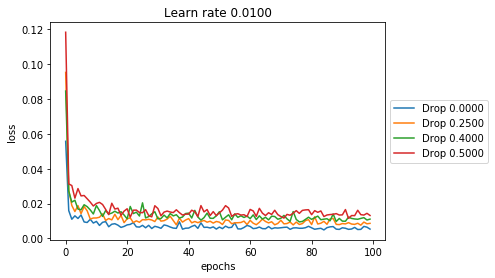


Learn rate: 0.0010
---------------------
 > Dropout: 0.00 Training error: 0.0075	Testing error: 0.0039
 > Dropout: 0.25 Training error: 0.0065	Testing error: 0.0125
 > Dropout: 0.40 Training error: 0.0063	Testing error: 0.0130
 > Dropout: 0.50 Training error: 0.0073	Testing error: 0.0175


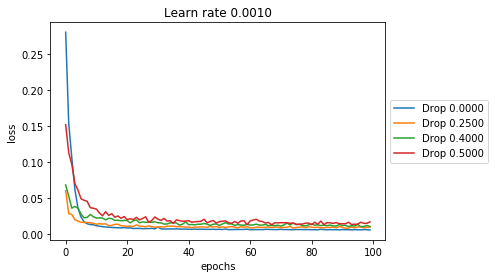


Learn rate: 0.0001
---------------------
 > Dropout: 0.00 Training error: 0.0135	Testing error: 0.0125
 > Dropout: 0.25 Training error: 0.0110	Testing error: 0.0150
 > Dropout: 0.40 Training error: 0.0217	Testing error: 0.0235
 > Dropout: 0.50 Training error: 0.0128	Testing error: 0.0159


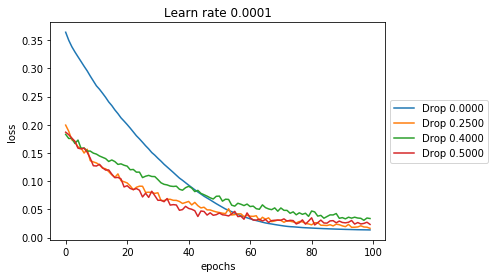

*** Best Live Model Summary***
Testing error: 0.0039
Best learning rate: 0.001
Best dropout rate: 0.0


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

window_size = 10
dropouts =  [0.0,0.25,0.4,0.50]
learn_rates = [0.01,0.001,0.0001]
batch_size = 50
epochs_live = 100

def test_live(X_train,y_train,X_test,y_test):
    best_model = None
    lowest_test_error = 2.0
    best_learn_rate = 0.0
    best_dropout_rate = 0.0
    for rate in learn_rates:
        print("\nLearn rate: {0:.4f}".format(rate))
        print('---------------------')
        lengend = []
        for dropout in dropouts:
            model = live_model(X_train,y_train,rate,dropout)
            history = model.fit(X_train, y_train, epochs=epochs_live, batch_size=batch_size, verbose=0)

            # print out training and testing errors
            training_error = model.evaluate(X_train, y_train, verbose=0)
            testing_error = model.evaluate(X_test, y_test, verbose=0)
            msg = " > Dropout: {0:.2f} Training error: {1:.4f}\tTesting error: {2:.4f}"
            print(msg.format(dropout, training_error,testing_error))
            
            #check if test error
            if lowest_test_error > testing_error:
                best_model = model
                lowest_test_error = testing_error
                best_learn_rate = rate
                best_dropout_rate = dropout
                
            #plot loss function
            plt.plot(history.history['loss'])
            lengend.append("Drop {0:.4f}".format(dropout)) 
    
        plt.title("Learn rate {0:.4f}".format(rate))
        plt.xlabel('epochs')
        plt.ylabel('loss')
        plt.legend(lengend,loc='center left', bbox_to_anchor=(1, 0.5))
        plt.show()
    
    return (best_model,lowest_test_error,best_learn_rate,best_dropout_rate)


seq_obj = MultiSequence(ticker,window_size,1)
dataset = seq_obj.original_data
X_train,y_train,X_test,y_test = split_data(seq_obj)

print("*** Live Model Testing ***")
print("=" * 40)        
results = test_live(X_train,y_train,X_test,y_test)


print("*** Best Live Model Summary***")
print("=" * 40) 
print("Testing error: {0:.4f}".format(results[1]))
print("Best learning rate: {}".format(results[2]))
print("Best dropout rate: {}".format(results[3]))

### Learn rate and dropout testing results
> * Looking at testing results we can see that learn of 0.01 and 0.001 performed better than 0.0001.
> * The dropout rates of 0.0, 0.25 and 0.40 had the best results.

### Epoch testing
> We perform a test to try and find the optimal epoch count.

In [ ]:
#get fourt tickers to perform out epoch test
ticker_epochs = [tickers[i][1] for i in range(4)]

window_size = 10
dropout_rate = 0.25
epochs_list = [50,100,200,500,1000]
batch_size = 50
learn_rate = 0.001

def test_epochs():
    """
    
    """
    for symbol in ticker_epochs:
        print("\nSymbol: {}".format(symbol))
        print('---------------------')
        seq_obj = MultiSequence(symbol,window_size,1)
        X_train,y_train,X_test,y_test = split_data(seq_obj)
        lowest_test_error = 2.0
        best_epoch = 0
        for epoch in epochs_list:
            model = live_model(X_train,y_train,learn_rate,dropout_rate)
            model.fit(X_train, y_train, epochs=epoch, batch_size=batch_size, verbose=0)

            # print out training and testing errors
            training_error = model.evaluate(X_train, y_train, verbose=0)
            testing_error = model.evaluate(X_test, y_test, verbose=0)
            msg = " > Epoch: {0:} \tTraining error: {1:.4f}\tTesting error: {2:.4f}"
            print(msg.format(epoch, training_error,testing_error))

            if lowest_test_error > testing_error:
                lowest_test_error = testing_error
                best_epoch = epoch
        
        #print best epoch for symbol
        print(" ==> Best epoch {0:} with testing error of {1:.4f}".format(best_epoch,lowest_test_error))

print("*** Epoch Model Testing ***")
print("=" * 40)        
test_epochs()

*** Epoch Model Testing ***

Symbol: MMM
---------------------


### Epoch testing conclusion
> Our epoch testing finds that there is no optimal epoch count but that we should try 100 and 200 and then return the model that performs the best. 

### Best model selection

> * Here we put together everything we learn from our testing to select model for a given ticker.


> * To select the best model for a ticker we define a function that accepts a list of window sizes, drop out rates, learn rates
and epoch.  


> * We graph the model peformance versus original dataset.

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

ticker = tickers[0][1]
window_sizes = [5,7,10]
dropouts =  [0.0,0.25,0.4]
learn_rates = [0.01,0.001]
epochs = [100,200,500]
batch_size = 50

def best_model(ticker, window_sizes, learn_rates, dropouts, epochs, batch_size):
    """
    
    """
    #our best model variables
    best_model = None
    lowest_test_error = 2.0
    best_training_error =0.0
    best_learn_rate = 0.0
    best_dropout_rate = 0.0
    best_epoch = 0
    best_window_size = 0
    
    counter = 1
    
    for window_size in window_sizes:
        print("\nWindow size: {}".format(window_size))
        print('---------------------')
        
        #prepare our sequence data
        seq_obj = MultiSequence(ticker,window_size,1)
        X_train,y_train,X_test,y_test = split_data(seq_obj)    
    
        for rate in learn_rates:
            for dropout in dropouts:
                for epoch in epochs:
                    model = live_model(X_train,y_train,rate,dropout)
                    model.fit(X_train, y_train, epochs=epoch, batch_size=batch_size, verbose=0)

                    # print out training and testing errors
                    training_error = model.evaluate(X_train, y_train, verbose=0)
                    testing_error = model.evaluate(X_test, y_test, verbose=0)
                    msg = " > Learn rate: {0:.4f} Dropout: {1:.2f}"
                    msg += " Epoch: {2:} Training error: {3:.4f} Testing error: {4:.4f}"
                    msg = str(counter) + "   " +msg.format(rate,dropout, epoch, training_error, testing_error)
                    print(msg)

                    #check if test error 
                    if lowest_test_error > testing_error:
                        best_model = model
                        lowest_test_error = testing_error
                        best_learn_rate = rate
                        best_dropout_rate = dropout
                        best_epoch = epoch
                        best_training_error = training_error 
                        best_window_size = window_size
                    
                    #increase our print counter
                    counter += 1
                        
    best_dict ={}
    best_dict["ticker"] = ticker
    best_dict["model"] = best_model
    best_dict["test_error"] =   "{0:.4f}".format(lowest_test_error) 
    best_dict["learn_rate"] = best_learn_rate
    best_dict["dropout"] = best_dropout_rate
    best_dict["epoch"] = best_epoch
    best_dict["train_error"] =  "{0:.4f}".format(best_training_error)  
    best_dict["window_size"] = best_window_size
    
    return best_dict


print("*** Best Model Selection for {} ***".format(ticker))
print("=" * 40)      
results = best_model(ticker, window_sizes, learn_rates, dropouts, epochs, batch_size)

In [ ]:
print("*** Best Model Selected Summary for {} ***".format(results["ticker"]))
print("=" * 40) 

print("Window size: {}".format(results["window_size"]))
print("Train error: {}".format(results["train_error"]))
print("Testing error: {}".format(results["test_error"]))
print("Learning rate: {}".format(results["learn_rate"]))
print("Dropout rate: {}".format(results["dropout"]))
print("Epochs: {}".format(results["epoch"]))

seq_obj = MultiSequence(results["ticker"],results["window_size"],1)
dataset = seq_obj.original_data
X_train,y_train,X_test,y_test = split_data(seq_obj)

graph_prediction(results["model"], X_train,X_test,dataset,results["window_size"])